In [706]:
import numpy as np 
import pandas as pd 

In [707]:
df = pd.read_csv('./spam.csv',encoding = "ISO-8859-1")
df.shape

(5572, 5)

Project will be in 8 stages 
1. Data Cleaning
2. EDA
3. Text preprocessing
4. Model building
5. Evaluation 
6. Improvements
7. Website
8. Deployment

<h1>Data Cleaning<h1>

In [708]:
# Data Cleaning
df.info

#drop last 3 columns
df.drop(columns=['Unnamed: 2','Unnamed: 3','Unnamed: 4'], inplace=True)
df.sample(5)

# renaming the columns
df.rename(columns={'v1': 'target', 'v2':'text'},inplace=True)
df.sample(5)

,target,text
5284,ham,Sent me ur email id soon
133,spam,Sunshine Quiz Wkly Q! Win a top Sony DVD playe...
3322,ham,"She said,'' do u mind if I go into the bedroom..."
2459,ham,Nope. Meanwhile she talk say make i greet you.
4467,ham,Much better now thanks lol


In [709]:
#encoding data into numerical values
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()
df['target'] = encoder.fit_transform(df['target'])

In [710]:
#missing values 
df.isnull().sum()

#removing duplicates
df = df.drop_duplicates(keep='first')
df.duplicated().sum()

0

<h1>Exploratory Data Analysis (EDA)<h2>

In [711]:
#check how many messages are spam or ham
df['target'].value_counts()

0    4516
1     653
Name: target, dtype: int64

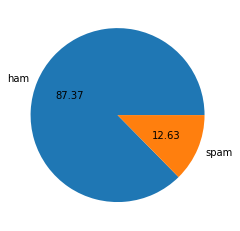

In [712]:
import matplotlib.pyplot as plt 

plt.pie(df['target'].value_counts(), labels=['ham','spam'], autopct="%0.2f")
plt.show()

In [713]:
# data is imbalaced so doing deep data analysis
import nltk
#nltk.download('punkt')
from nltk.corpus import stopwords
import string
from nltk.stem.porter import PorterStemmer

#for deep analysis we will make 3 new columns: 
#No of characters in email
#No of words in email
#No of sentences in email

In [714]:
df['num_characters'] = df['text'].apply(len)
df['num_words'] = df['text'].apply(lambda x: len(nltk.word_tokenize(x)))
df['num_sentences'] = df['text'].apply(lambda x: len(nltk.sent_tokenize(x)))


In [715]:

#describing the data
df[['num_characters', 'num_words', 'num_sentences']].describe()
#for ham
df[df['target'] == 0][['num_characters', 'num_words', 'num_sentences']].describe()
#for spam
df[df['target'] == 1][['num_characters', 'num_words', 'num_sentences']].describe()

,num_characters,num_words,num_sentences
count,653.000000,653.000000,653.000000
mean,137.891271,27.667688,2.967841
std,30.137753,7.008418,1.483201
min,13.000000,2.000000,1.000000
25%,132.000000,25.000000,2.000000
50%,149.000000,29.000000,3.000000
75%,157.000000,32.000000,4.000000
max,224.000000,46.000000,8.000000


<AxesSubplot:xlabel='num_characters', ylabel='Count'>

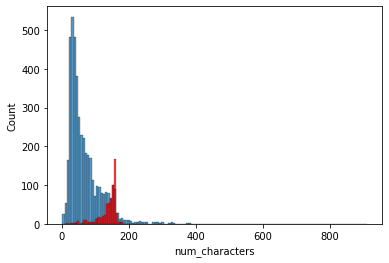

In [716]:
import seaborn as sns 
#extract all ham
sns.histplot(df[df['target'] == 0]['num_characters'])
sns.histplot(df[df['target'] == 1]['num_characters'], color='red')


<AxesSubplot:xlabel='num_words', ylabel='Count'>

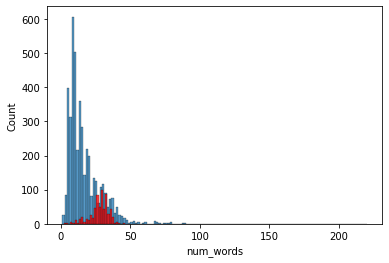

In [717]:
sns.histplot(df[df['target'] == 0]['num_words'])
sns.histplot(df[df['target'] == 1]['num_words'], color='red')

<AxesSubplot:xlabel='num_sentences', ylabel='Count'>

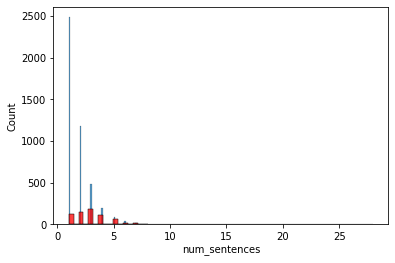

In [718]:
sns.histplot(df[df['target'] == 0]['num_sentences'])
sns.histplot(df[df['target'] == 1]['num_sentences'], color='red')

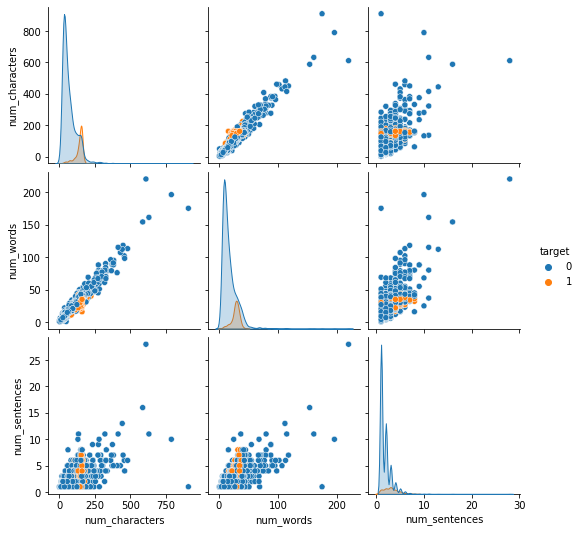

In [719]:
sns.pairplot(df,hue='target')

<AxesSubplot:>

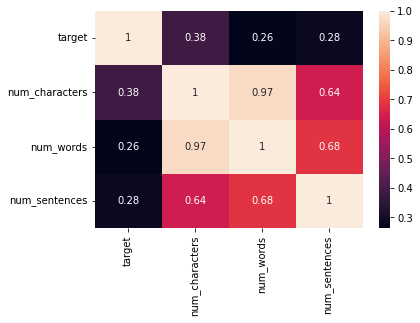

In [720]:
# check correlations
sns.heatmap(df.corr(),annot=True)

<h2>Data Preprocessing</h2>
 1. lower case
 2. Tokenization
 3. Removing special character
 4. Removing stop words and punctuations
 5. Stemming

In [721]:
 
def transform_text(text):
    text = text.lower()
    text = nltk.word_tokenize(text)
    y = []
    
    #removing special character
    for i in text: 
        if i.isalnum():
            y.append(i)
    
    #stopwords removal 
    text = y[:]
    y.clear()
    
    for i in text:
        if i not in stopwords.words('english') and i not in string.punctuation:
            y.append(i)
    
    #stemming
    ps = PorterStemmer()
    text = y[:]
    y.clear()
    
    for i in text: 
        y.append(ps.stem(i))        
                            
    return " ".join(y)   

In [722]:
df['transformed_text'] = df['text'].apply(transform_text ) 

In [723]:
# making word cloud 
from wordcloud import WordCloud

wc = WordCloud(width=500,height=500,min_font_size=10,background_color='white')


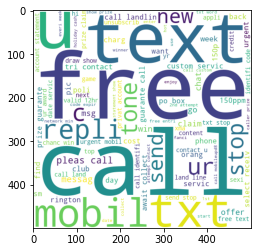

In [724]:
spam_wc = wc.generate(df[df['target'] == 1]['transformed_text'].str.cat(sep=" "))
plt.imshow(spam_wc)

In [725]:
# now we want top 30 or 50 words in ham or spam 
spam_corpus = []
for msg in df[df['target'] == 1]['transformed_text'].tolist():
    for word in msg.split():
        spam_corpus.append(word)


In [726]:
# from collections import Counter
# sns.barplot(pd.DataFrame(Counter(spam_corpus).most_common(30))[0],pd.DataFrame(Counter(spam_corpus).most_common(30))[1])
# plt.xticks(rotation='vertical')
# plt.show()

In [727]:
ham_corpus = []
for msg in df[df['target'] == 0]['transformed_text'].tolist():
    for word in msg.split():
        ham_corpus.append(word)


<h2>Model Building</h2>

In [728]:
# vectorizing text to numerical values
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

cv = CountVectorizer()
tfidf = TfidfVectorizer(max_features=3000)

In [729]:
X = tfidf.fit_transform(df['transformed_text']).toarray()
X.shape
y = df['target'].values

In [730]:
# from sklearn.preprocessing import MinMaxScaler

# scaler = MinMaxScaler()
# X = scaler.fit_transform(X)

In [731]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X,y,test_size=0.2,random_state=2)

In [732]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score

In [733]:
mnb = MultinomialNB()
mnb.fit(X_train,Y_train)
y_pred2 = mnb.predict(X_test)
print(f"Accuracy: {accuracy_score(Y_test,y_pred2)}")
print(f"Confusion Matrix:\n {confusion_matrix(Y_test,y_pred2)}")
print(f"Precision Score: {precision_score(Y_test,y_pred2)}")

Accuracy: 0.9709864603481625
Confusion Matrix:
 [[896   0]
 [ 30 108]]
Precision Score: 1.0


<h2>Model Comparions</h2>

In [734]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import GradientBoostingClassifier

In [735]:
svc = SVC(kernel='sigmoid', gamma=1.0)
knc = KNeighborsClassifier()
mnb = MultinomialNB()
dtc = DecisionTreeClassifier(max_depth=5)
lrc = LogisticRegression(solver='liblinear', penalty='l1')
rfc = RandomForestClassifier(n_estimators=50, random_state=2)
abc = AdaBoostClassifier(n_estimators=50, random_state=2)
bc = BaggingClassifier(n_estimators=50, random_state=2)
etc = ExtraTreesClassifier(n_estimators=50, random_state=2)
gbdt = GradientBoostingClassifier(n_estimators=50,random_state=2)

In [736]:
clfs = {
    'SVC' : svc,
    'KN' : knc, 
    'NB': mnb, 
    'DT': dtc, 
    'LR': lrc, 
    'RF': rfc, 
    'AdaBoost': abc, 
    'BgC': bc, 
    'ETC': etc,
    'GBDT':gbdt,
}

In [737]:
def train_classifier(clf,X_train,y_train,X_test,y_test):
    clf.fit(X_train,y_train)
    y_pred = clf.predict(X_test)
    accuracy = accuracy_score(y_test,y_pred)
    precision = precision_score(y_test,y_pred)
    
    return accuracy,precision

In [738]:
accuracy_scores = []
precision_scores = []

for name,clf in clfs.items():
    
    current_accuracy,current_precision = train_classifier(clf, X_train,Y_train,X_test,Y_test)
    
    print("For ",name)
    print("Accuracy - ",current_accuracy)
    print("Precision - ",current_precision)
    
    accuracy_scores.append(current_accuracy)
    precision_scores.append(current_precision)

For  SVC
Accuracy -  0.9758220502901354
Precision -  0.9747899159663865
For  KN
Accuracy -  0.9052224371373307
Precision -  1.0
For  NB
Accuracy -  0.9709864603481625
Precision -  1.0
For  DT
Accuracy -  0.9274661508704062
Precision -  0.8118811881188119
For  LR
Accuracy -  0.9584139264990329
Precision -  0.9702970297029703
For  RF
Accuracy -  0.9748549323017408
Precision -  0.9827586206896551
For  AdaBoost
Accuracy -  0.960348162475822
Precision -  0.9292035398230089
For  BgC
Accuracy -  0.9574468085106383
Precision -  0.8671875
For  ETC
Accuracy -  0.9748549323017408
Precision -  0.9745762711864406


In [ ]:
performance_df = pd.DataFrame({'Algorithm':clfs.keys(),'Accuracy':accuracy_scores,'Precision':precision_scores}).sort_values('Precision',ascending=False)
performance_df

In [ ]:
performance_df1 = pd.melt(performance_df, id_vars = "Algorithm")
performance_df1

In [ ]:
sns.catplot(x = 'Algorithm', y='value', 
               hue = 'variable',data=performance_df1, kind='bar',height=5)
plt.ylim(0.5,1.0)
plt.xticks(rotation='vertical')
plt.show()

In [ ]:
'''
improve model:
    1. change the max_features parameter of tfidf
'''


In [ ]:
# creating a pipline
import pickle
pickle.dump(tfif,open('vectorizer.pkl','wb'))
pickle.dump(mnb,open('model.pkl','wb'))